## Getting the Data

## Preparing the Data

In [1]:
import pandas as pd

dataset_url = "https://git.io/nlp-with-transformers"
df_issues = pd.read_json(dataset_url, lines=True)
print(f'DataFrame shape: {df_issues.shape}')

DataFrame shape: (9930, 26)


In [2]:
cols = ["url", "id", "title", "user", "labels", "state", "created_at", "body"]
df_issues.loc[2, cols].to_frame()

,2
url,https://api.github.com/repos/huggingface/trans...
id,849529761
title,[DeepSpeed] ZeRO stage 3 integration: getting ...
user,"{'login': 'stas00', 'id': 10676103, 'node_id':..."
labels,"[{'id': 2659267025, 'node_id': 'MDU6TGFiZWwyNj..."
state,open
created_at,2021-04-02 23:40:42
body,"**[This is not yet alive, preparing for the re..."


In [3]:
# We are only interestes in the name field of each label object
df_issues["labels"] = (df_issues["labels"]
                      .apply(lambda x: [meta["name"] for meta in x]))

In [4]:
df_issues[["labels"]].head()

,labels
0,[]
1,[]
2,[DeepSpeed]
3,[]
4,[]


In [5]:
# now each row in the labels colimn is a list of github labels, so we can compute the length of each row to find the  number of labels pers issue
df_issues["labels"].apply(lambda x : len(x)).value_counts().to_frame().T

labels,0,1,2,3,4,5
count,6440,3057,305,100,25,3


In [6]:
# top10 most frequent labels in the dataset
df_counts = df_issues["labels"].explode().value_counts() # "exploding" the labels column so that each label in the list becomes a row
print(f'Number of labels: {len(df_counts)}')
df_counts.to_frame().head(10).T

Number of labels: 65


labels,wontfix,model card,Core: Tokenization,New model,Core: Modeling,Help wanted,Good First Issue,Usage,Core: Pipeline,Feature request
count,2284,649,106,98,64,52,50,46,42,41


In [7]:
# filters the dataset for the subset of labels that we'll work with
label_map = {"Core: Tokenization": "tokenization",
            "New model": "new model",
            "Core: Modeling": "model training",
            "Usage": "usage",
            "Core: Pipeline": "pipeline",
            "TensorFlow": "tensorflow or tf",
            "PyTorch": "pytorch",
            "Examples": "examples",
            "Documentation": "documentation"}

def filter_labels(x):
    return [label_map[label] for label in x if label in label_map]

df_issues["labels"] = df_issues["labels"].apply(filter_labels)
all_labels = list(label_map.values())

In [8]:
df_counts = df_issues["labels"].explode().value_counts()
df_counts.to_frame().T

labels,tokenization,new model,model training,usage,pipeline,tensorflow or tf,pytorch,documentation,examples
count,106,98,64,46,42,41,37,28,24


In [9]:
# we'll find it useful to treat the unlabeled issues as a separate training split
df_issues["split"] = "unlabeled"
mask = df_issues["labels"].apply(lambda x: len(x)) > 0
df_issues.loc[mask, "split"] = "labeled"
df_issues["split"].value_counts().to_frame()

,count
split,
unlabeled,9489
labeled,441


In [10]:
for column in ["title", "body", "labels"]:
    print(f"{column}: {df_issues[column].iloc[24][:500]}\n")

title: Enable multiple `eval_dataset` in `Trainer` API

body: # 🚀 Feature request

Allow for two or more (equally long) validation sets to be passed to the `Trainer` API which are evaluated sequentially each `eval_steps`.

## Motivation

You can find my motivation in this [thread](https://discuss.huggingface.co/t/use-trainer-api-with-two-valiation-sets/5212) and the referenced paper. My idea would be to evaluate language model pre-training on an overlapping validation set (coming from the same data distribution as the training set) and a non-overlapp

labels: []



In [11]:
# title contains information, so let's concatenate it with the issue's description on the body field
df_issues["text"] = (df_issues
                    .apply(lambda x: x["title"] + "\n\n" + x["body"], axis=1))

In [12]:
# check duplicates
len_before = len(df_issues)
df_issues = df_issues.drop_duplicates(subset="text")
print(f"Removed {(len_before - len(df_issues))/len_before:.2%} duplicates")

Removed 1.88% duplicates


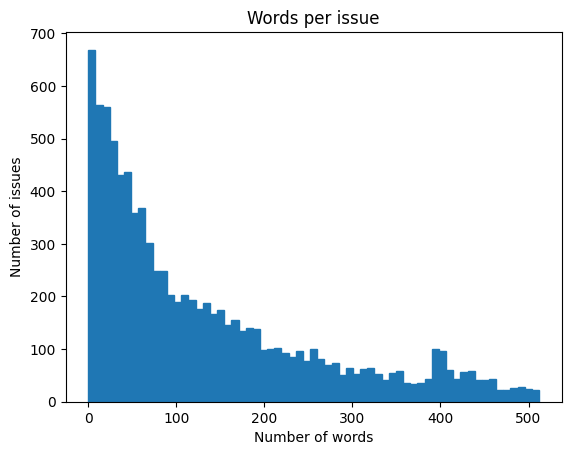

In [13]:
# quick look at the number of words of each text, to see if we'll lose information when truncating
import numpy as np
import matplotlib.pyplot as plt

(df_issues["text"].str.split().apply(len)
.hist(bins=np.linspace(0, 512, 64), grid=False, edgecolor="C0"))
plt.title("Words per issue")
plt.xlabel("Number of words")
plt.ylabel("Number of issues")
plt.show()

## Creating Training Sets

Transform our set of labels into a format that the model can process

In [14]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
mlb.fit([all_labels])
mlb.transform([["tokenization", "new model"], ["pytorch"]])

array([[0, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0]])

In [15]:
# iteratively achieve balanced labels
from skmultilearn.model_selection import iterative_train_test_split

def balanced_split(df, test_size=0.5):
    ind = np.expand_dims(np.arange(len(df)), axis=1)
    labels = mlb.transform(df["labels"])
    ind_train, _, ind_test, _ = iterative_train_test_split(ind, labels, test_size)

    return df.iloc[ind_train[:, 0]], df.iloc[ind_test[:, 0]]

In [16]:
# with the balanced_split() function, we can split the data into supervised and unsupervised datasets, and then create balanced training, validation, and test sets for the supervised part:
from sklearn.model_selection import train_test_split

df_clean = df_issues[["text", "labels", "split"]].reset_index(drop=True).copy()
df_unsup = df_clean.loc[df_clean["split"] == "unlabeled", ["text", "labels"]]
df_sup = df_clean.loc[df_clean["split"] == "labeled", ["text", "labels"]]

np.random.seed(0)
df_train, df_tmp = balanced_split(df_sup, test_size=0.5)
df_valid, df_test = balanced_split(df_tmp, test_size=0.5)

In [17]:
# Let's create a DatsetDict with all the splits
from datasets import Dataset, DatasetDict

ds = DatasetDict({
    "train": Dataset.from_pandas(df_train.reset_index(drop=True)),
    "valid": Dataset.from_pandas(df_valid.reset_index(drop=True)),
    "test": Dataset.from_pandas(df_test.reset_index(drop=True)),
    "unsup": Dataset.from_pandas(df_unsup.reset_index(drop=True)),
})

## Creating Training Slices

In [18]:
np.random.seed(0)
all_indices = np.expand_dims(list(range(len(ds["train"]))), axis=1)
indices_pool = all_indices
labels = mlb.transform(ds["train"]["labels"])
train_samples = [8, 16, 32, 64, 128]
train_slices, last_k = [], 0

for i, k in enumerate(train_samples):
    # Split off samples necessary to fill the gap to the next split size
    indices_pool, labels, new_slice, _ = iterative_train_test_split(
        indices_pool, labels, (k-last_k)/len(labels)
    )
    last_k = k
    if i==0: train_slices.append(new_slice)
    else: train_slices.append(np.concatenate((train_slices[-1], new_slice)))

# Add full dataset as last slice
train_slices.append(all_indices), train_samples.append(len(ds["train"]))
train_slices = [np.squeeze(train_slice) for train_slice in train_slices]

In [19]:
print("Target split sizes:")
print(train_samples)
print("Actual split sizes:")
print([len(x) for x in train_slices])

Target split sizes:
[8, 16, 32, 64, 128, 223]
Actual split sizes:
[10, 19, 36, 68, 134, 223]


Note that this iterative approach only approximately splits the samples to the desired size, since it is not always possible to find a balanced split at a given split size

# Implementing a Naive Bayesline

In [20]:
# we train L binary classifiers for L labels. Let's use a multilabel binarizer to create a new label_ids column in our training sets.
def prepare_labels(batch):
    batch["label_ids"] = mlb.transform(batch["labels"])
    return batch

In [21]:
ds = ds.map(prepare_labels, batched=True)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [22]:
# we'll use micro and macro f1-scores. Since we'll be avaluating each model across different-sized training splits, let's create a defaultdict with a list to store the scores per split
from collections import defaultdict

macro_scores, micro_scores = defaultdict(list), defaultdict(list)

In [23]:
# train the baseline model and evaluate our classifier across increasing training set sizes
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.feature_extraction.text import CountVectorizer

for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    y_train = np.array(ds_train_sample["label_ids"]) # encode the labels
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode out texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_sample["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True
    )
    # store metrics
    macro_scores["Naive Bayes"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes"].append(clf_report["micro avg"]["f1-score"])

In [24]:
import matplotlib.pyplot as plt

def plot_metrics(micro_scores, macro_scores, sample_sizes, current_model):
    fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10,4), sharey=True)

    for run in micro_scores.keys():
        if run == current_model:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linewidth=2)
            ax1.plot(sample_sizes, macro_scores[run], label=run, linewidth=2)
        else:
            ax0.plot(sample_sizes, micro_scores[run], label=run, linestyle="dashed")
            ax1.plot(sample_sizes, macro_scores[run], label=run, linestyle="dashed")

    ax0.set_title("Micro F1 scores")
    ax1.set_title("Macro F1 scores")
    ax0.set_ylabel("Test set F1 score")
    ax0.legend(loc="lower right")
    for ax in [ax0, ax1]:
        ax.set_xlabel("Number of training samples")
        ax.set_xscale("log")
        ax.set_xticks(sample_sizes)
        ax.set_xticklabels(sample_sizes)
        ax.minorticks_off()
    plt.tight_layout()
    plt.show()    

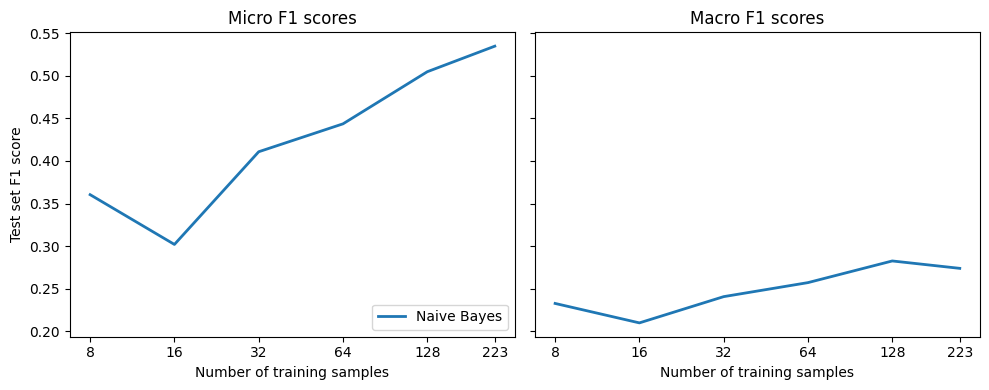

In [25]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes")

# Working with No Labeled Data

first technique to consider *zero-shot classification*

we will cheat a bit since we'll still use test data to measure the performance, but we'll not use any data to train the model

Make use of a pretrained model without any additional fine-tuning on you task-specific corpus.

Following toy problem: you have 2 children, one of them likes movies with cars while the other enjoys movies with animals better. Build a function that tells you what topic a new movie is about.
1st thing to try: BERT-base in the fill-mask pipeline

In [26]:
from transformers import pipeline

pipe = pipeline("fill-mask", model="bert-base-uncased")

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/ssanchez/env/transformers/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feed

In [27]:
movie_desc = "The main characters of the movie madacascar \
are a lion, a zebra, a giraffe, and a hippo. "
prompt = "The movie is about [MASK]."

output = pipe(movie_desc + prompt)
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token lions:	0.066%
Token birds:	0.025%
Token love:	0.015%
Token hunting:	0.013%


In [28]:
output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token animals:	0.103%
Token cars:	0.001%


In [29]:
movie_desc = "In the movie transformers aliens \
can morph into a wide range of vehicles."

output = pipe(movie_desc + prompt, targets=["animals", "cars"])
for element in output:
    print(f"Token {element['token_str']}:\t{element['score']:.3f}%")

Token cars:	0.139%
Token animals:	0.006%


It illustrates the key idea of many approaches discussed in this chapter: find a way to adapt a pretrained model for another task without training it.

## Using Text entailment classifier

In [30]:
from transformers import pipeline

pipe = pipeline("zero-shot-classification", device=0)

No model was supplied, defaulted to facebook/bart-large-mnli and revision d7645e1 (https://huggingface.co/facebook/bart-large-mnli).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [31]:
sample = ds["train"][0]
print(f"Labels: {sample['labels']}")

output = pipe(sample["text"], all_labels, multi_label=True)
print(output["sequence"][:400])
print("\nPredictions:")

for label, score, in zip(output["labels"], output["scores"]):
    print(f"{label}, {score:.2f}")

Labels: ['new model']
Add new CANINE model

# 🌟 New model addition

## Model description

Google recently proposed a new **C**haracter **A**rchitecture with **N**o tokenization **I**n **N**eural **E**ncoders architecture (CANINE). Not only the title is exciting:

> Pipelined NLP systems have largely been superseded by end-to-end neural modeling, yet nearly all commonly-used models still require an explicit tokeni

Predictions:
new model, 0.98
tensorflow or tf, 0.37
examples, 0.34
usage, 0.30
pytorch, 0.25
documentation, 0.25
model training, 0.24
tokenization, 0.17
pipeline, 0.16


In [32]:
def zero_shot_pipeline(example):
    output = pipe(example['text'], all_labels, mutli_label=True)
    example["predicted_labels"] = output["labels"]
    example["scores"] = output["scores"]
    return example

In [33]:
ds_zero_shot = ds["valid"].map(zero_shot_pipeline)

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


The next step is to determine which set of labels should be asigned to each example.
There are a few options we can experiment with:

- Define a threshold and select all labels above
- Pick the top *k* labels with the *k* highest scores

In [34]:
# helper function to determine which method is best
def get_preds(example, threshold=None, topk=None):
    preds = []
    if threshold:
        for label, score in zip(example["predicted_labels"], example["scores"]):
            if score >= threshold:
                preds.append(label)
    elif topk:
        for i in range(topk):
            preds.append(example["predicted_labels"][i])
    else:
        raise ValueError("Set either 'threshold' or 'topk'.")
    return {"pred_label_ids": list(np.squeeze(mlb.transform([preds])))}

In [35]:
# helper function that returns the scikit-learn classification report from a dataset with the predicted labels
def get_clf_report(ds):
    y_true = np.array(ds["label_ids"])
    y_pred = np.array(ds["pred_label_ids"])
    return classification_report(
        y_true, y_pred, target_names=mlb.classes_, zero_division=0,
        output_dict=True
    )

Let's start with the top-k method by increasing k for serveral values and then plotting the micro and macro F1 scores across the validation set.

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

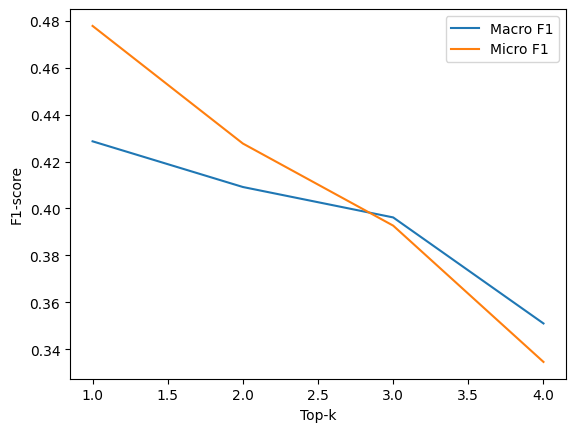

In [36]:
macros, micros = [], []
topks = [1, 2, 3, 4]
for topk in topks:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                   fn_kwargs={'topk': topk})
    clf_report = get_clf_report(ds_zero_shot)
    macros.append(clf_report['macro avg']["f1-score"])
    micros.append(clf_report['micro avg']["f1-score"])

plt.plot(topks, macros, label='Macro F1')
plt.plot(topks, micros, label='Micro F1')
plt.xlabel("Top-k")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [37]:
macros, micros = [], []
thresholds = np.linspace(0.01, 1, 100)
for th in thresholds:
    ds_zero_shot = ds_zero_shot.map(get_preds, batched=False,
                                   fn_kwargs={'threshold': th})
    clf_report = get_clf_report(ds_zero_shot)
    macros.append(clf_report['macro avg']["f1-score"])
    micros.append(clf_report['micro avg']["f1-score"])

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

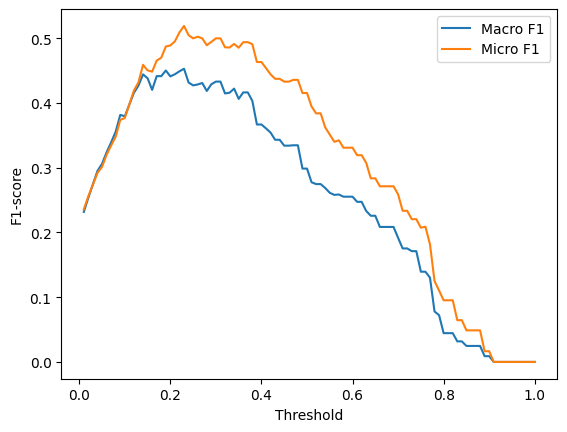

In [38]:
plt.plot(thresholds, macros, label='Macro F1')
plt.plot(thresholds, micros, label='Micro F1')
plt.xlabel("Threshold")
plt.ylabel("F1-score")
plt.legend(loc="best")
plt.show()

In [69]:
best_t, best_micro = thresholds[np.argmax(micros)], np.max(micros)
print(f'Best threshold (micro): {best_t} with F1-score {best_micro:.2f}')
best_t, best_macro = thresholds[np.argmax(macros)], np.max(macros)
print(f'Best threshold (macro): {best_t} with F1-score {best_macro:.2f}')

Best threshold (micro): 0.23 with F1-score 0.52
Best threshold (macro): 0.23 with F1-score 0.45


Since threshold at 0.23 works best, let's use this to compare zero-shot classification against Naive Bayes on the test set:

In [39]:
ds_zero_shot = ds['test'].map(zero_shot_pipeline)
ds_zero_shot_threshold = ds_zero_shot.map(get_preds, fn_kwargs={'threshold': 0.23})
ds_zero_shot_topk = ds_zero_shot.map(get_preds, fn_kwargs={'topk': 1})
clf_report_threshold = get_clf_report(ds_zero_shot_threshold)
clf_report_topk = get_clf_report(ds_zero_shot_topk)
for train_slice in train_slices:
    macro_scores['Zero Shot (threshold)'].append(clf_report_threshold['macro avg']['f1-score'])
    micro_scores['Zero Shot (threshold)'].append(clf_report_threshold['micro avg']['f1-score'])

    macro_scores['Zero Shot (topk)'].append(clf_report_topk['macro avg']['f1-score'])
    micro_scores['Zero Shot (topk)'].append(clf_report_topk['micro avg']['f1-score'])

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

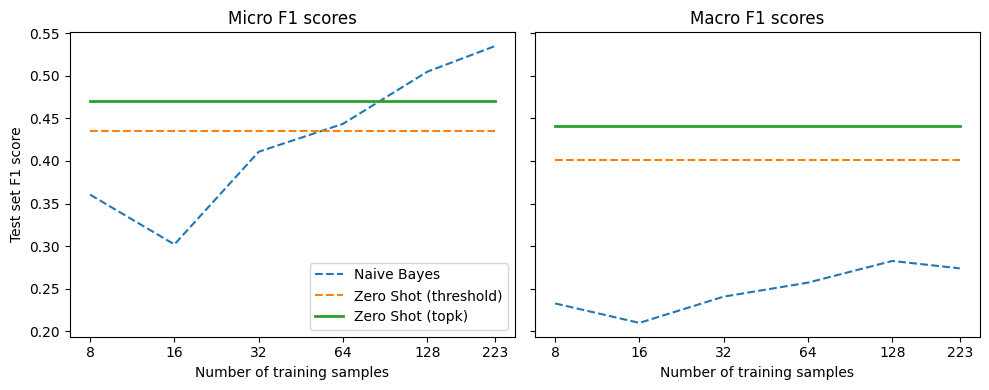

In [40]:
plot_metrics(micro_scores, macro_scores, train_samples, "Zero Shot (topk)")

Comparing the zero-shot pipeline to the baseline, we observe 2 things:

1. If we have less than 50 labeled samples, the zero-shot pipeline handily outperforms the baseline
2. Even above 50 samples, the performance of the zero-shot pipeline is superior when considering both the macro and micro f1 scores. The results for the micro f1 tell us that the baseline performs well on the frequent classes, while the zero-shot pipeline excels at those since it does not require any examples to learn from.

If you find it difficult to get good results on your own dataset, here aare a few things you can do to improve the zero-shot pipeline:

- Thw way the pipeline works makes it very sensitive to the names of the labels. Either try using different names or use several names in parallel and aggreagate them in an extra step.
- You can improve the form of the hypothesis. Pass any other text to the pipeline.

# Working with a Few Labels

We'll have a look at how we can best leverage the few, precious labeled examples that we have.

## Data Augmentation

Generate new training examples from the existing ones.

- Back translation

take a text in the source language, translate it into one or more target languages using machine translation,and then translate it back to the source language. Back translation tends to work best for high-resource languages or corpora that don't contain too many domain-specific words.
  
- Token perturbations

Given a text from the training set, randomly choose and perform simple transformations like random synonym replacement, word insertion, swap, or deletion.

In [41]:
# We'll focus on synonym replacement
# We'll use ContextualWordEmbsAug augmenter from NlpAug to leverage the contextual word embeddings of DistilBERT
from transformers import set_seed
import nlpaug.augmenter.word as naw

set_seed(3)
aug = naw.ContextualWordEmbsAug(model_path="distilbert-base-uncased", device="cpu", action="substitute")

In [73]:
text = "Transformers are the most popular toys"
print(f"Original text: {text}")
print(f"Augmented text: {aug.augment(text)}")

Original text: Transformers are the most popular toys
Augmented text: ['transformers get the most interesting toys']


In [42]:
def augment_text(batch, transformations_per_example=1):
    text_aug, label_ids = [], []
    for text, labels in zip(batch["text"], batch["label_ids"]):
        text_aug += [text]
        label_ids += [labels]
        for _ in range(transformations_per_example):
            text_aug += [aug.augment(text)[0]] # HAD TO select the first element. It returned a list of strings, and must be just a string
            label_ids += [labels]
    return {"text": text_aug, "label_ids": label_ids}

In [43]:
# Train Naive Bayes + Augmentation
for train_slice in train_slices:
    # Get training slice and test data
    ds_train_sample = ds["train"].select(train_slice)
    # Flatten augmentations and align labels!
    ds_train_aug = (ds_train_sample.map(
        augment_text, batched=True, remove_columns=ds_train_sample.column_names)
                    .shuffle(seed=42))
    y_train = np.array(ds_train_aug["label_ids"])
    y_test = np.array(ds["test"]["label_ids"])
    # Use a simple count vectorizer to encode our texts as token counts
    count_vect = CountVectorizer()
    X_train_counts = count_vect.fit_transform(ds_train_aug["text"])
    X_test_counts = count_vect.transform(ds["test"]["text"])
    # Create and train our model!
    classifier = BinaryRelevance(classifier=MultinomialNB())
    classifier.fit(X_train_counts, y_train)
    # Generate predictions and evaluate
    y_pred_test = classifier.predict(X_test_counts)
    clf_report = classification_report(
        y_test, y_pred_test, target_names=mlb.classes_, zero_division=0,
        output_dict=True)
    # Store metrics
    macro_scores["Naive Bayes + Aug"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Naive Bayes + Aug"].append(clf_report["micro avg"]["f1-score"])

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

Map:   0%|          | 0/19 [00:00<?, ? examples/s]

Map:   0%|          | 0/36 [00:00<?, ? examples/s]

Map:   0%|          | 0/68 [00:00<?, ? examples/s]

Map:   0%|          | 0/134 [00:00<?, ? examples/s]

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

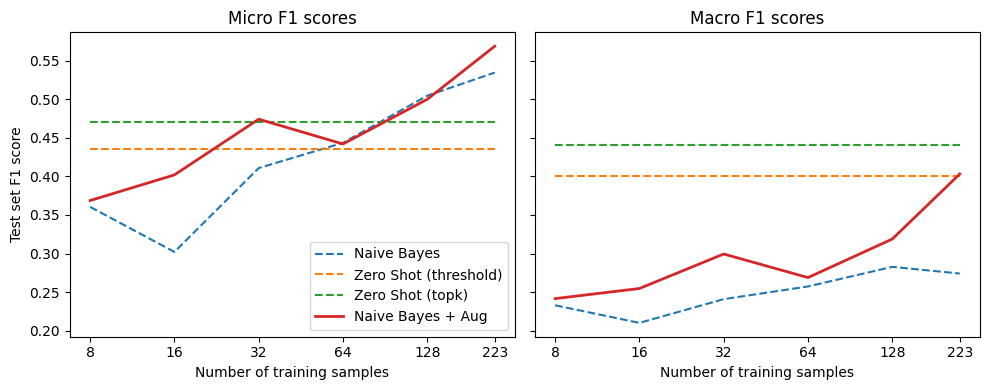

In [44]:
plot_metrics(micro_scores, macro_scores, train_samples, "Naive Bayes + Aug")

## Using Embeddings as a Lookup Table

LLM have been shown to be excellent at solving tasks with limited data. The reason is that these models learn useful representations of text that encode information across many dimensions (sentiment, topic, text structure, and more). For this reason, the embeddings of LLMs can be used to develop a semantic search engine, fins similar documents or comments, or even classify text.

We'll create a text classifier that's modeled after the OpenAI API classification endpoint.

1. Use the language model to embed all labeled texts.
2. Perfrorm a nearest neighbor search over the stored embeddings.
3. Aggregate the labels of the nearest neighbors to get a prediction.

Let's write a helper function that takes a list of texts and uses the model to create a single-vector representatios for each text.
GPT-2 will actually return one embedding vector per token. Bu what we really want is a single embedding vector fo the whole sentence.

To deal with this, we can use a technique called *pooling*. One of the simplest pooling methods is to average the token embeddings (*mean pooling*). With it, the only thing we need to watch out for is that we don't include padding tokens in the average, so we can use the attention mask to handle that.

In [45]:
import torch
from transformers import AutoTokenizer, AutoModel

model_ckpt = "miguelvictor/python-gpt2-large"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)

def mean_pooling(model_output, attention_mask):
    # Extract the token embeddings
    token_embeddings = model_output[0]
    # Compute the attention mask
    input_mask_expanded = (attention_mask
                          .unsqueeze(-1)
                          .expand(token_embeddings.size())
                          .float())
    # sum the embedding, but ignore masked tokens
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    # return the average as a single vector
    return sum_embeddings / sum_mask

def embed_text(examples):
    inputs = tokenizer(examples["text"], padding=True, truncation=True,
                      max_length=128, return_tensors='pt')
    with torch.no_grad():
        model_output = model(**inputs)
    pooled_embeds = mean_pooling(model_output, inputs["attention_mask"])
    return {"embedding": pooled_embeds.cpu().numpy()}

/home/ssanchez/env/transformers/lib/python3.8/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [77]:
# Get the embedings of each split
# GPT-style models don't have a padding token. We need to add one before we can get the embeddings in a
# batched fasion as implemented in the preceding code.
tokenizer.pad_token = tokenizer.eos_token
embs_train = ds["train"].map(embed_text, batched=True, batch_size=16)
embs_valid = ds["valid"].map(embed_text, batched=True, batch_size=16)
embs_test = ds["test"].map(embed_text, batched=True, batch_size=16)

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Now that we have all the embeddings, we need to set up a system to search them.

Calculate the cosine similarity between a new text embedding that we'l quert and the existing embeddings in the training set.
Alternatively we can use a built-in structure of Datasets called a *FAISS index*. You can think of it as a search engine for embeddings.

In [78]:
# add out training embeddings to the datasest as follows
embs_train.add_faiss_index("embedding")

  0%|          | 0/1 [00:00<?, ?it/s]

Dataset({
    features: ['text', 'labels', 'label_ids', 'embedding'],
    num_rows: 223
})

In [98]:
# we can now perform a nearest neighbor lookup. get_nearest_examples() returns the closest as well as the matching score for each one.
i, k = 0, 3 # select the first query and 3 nearest neighbors
rn, nl = "\r\n\r\n", "\n" # Used to remoce newlines in text for compact display

queries = np.array(embs_valid[i]["embedding"], dtype=np.float32)
scores, samples = embs_train.get_nearest_examples("embedding", queries, k=k)

print(f"QUERY LABELS: {embs_valid[i]['labels']}")
print(f"QUERY TEXT:\n{embs_valid[i]['text'][:200].replace(rn, nl)} [...]\n")
print("="*50)
print(f"Retrieved documents:")
for score, label, text in zip(scores, samples['labels'], samples['text']):
    print("="*50)
    print(f"TEXT:\n{text[:200].replace(rn, nl)}")
    print(f"SCORE: {score:.2f}")
    print(f"LABELS: {label}")

QUERY LABELS: ['new model']
QUERY TEXT:
Implementing efficient self attention in T5

# 🌟 New model addition
My teammates and I (including @ice-americano) would like to use efficient self attention methods such as Linformer, Performer and [...]

Retrieved documents:
TEXT:
Add Linformer model

# 🌟 New model addition
## Model description
### Linformer: Self-Attention with Linear Complexity
Paper published June 9th on ArXiv: https://arxiv.org/abs/2006.04768
La
SCORE: 54.92
LABELS: ['new model']
TEXT:
Add FAVOR+ / Performer attention

# 🌟 FAVOR+ / Performer attention addition
Are there any plans to add this new attention approximation block to Transformers library?
## Model description
The n
SCORE: 57.90
LABELS: ['new model']
TEXT:
Implement DeLighT: Very Deep and Light-weight Transformers

# 🌟 New model addition
## Model description
DeLight, that delivers similar or better performance than transformer-based models with sign
SCORE: 60.12
LABELS: ['new model']


What is the best value for *k*? Similarly, how we should then aggregate the labels of the retrieved documents?

Let's investigate this systemically: we'll try several values for k and then vary the threshold m < k for label assignment with a helper function.

Instead of looping over each sample in the validation set we can make use of the function get_nearest_examples_batch()

In [100]:
def get_sample_preds(sample, m):
    return (np.sum(sample["label_ids"], axis=0) >= m).astype(int)

def find_best_k_m(ds_train, valid_queries, valid_labels, max_k=17):
    max_k = min(len(ds_train), max_k)
    perf_micro = np.zeros((max_k, max_k))
    perf_macro = np.zeros((max_k, max_k))
    for k in range(1, max_k):
        for m in range(1, k+1):
            _, samples = ds_train.get_nearest_examples_batch("embedding", valid_queries, k=k)
            y_pred = np.array([get_sample_preds(s, m) for s in samples])
            clf_report = classification_report(valid_labels, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
            perf_micro[k, m] = clf_report['micro avg']['f1-score']
            perf_macro[k, m] = clf_report['macro avg']['f1-score']
    return perf_micro, perf_macro

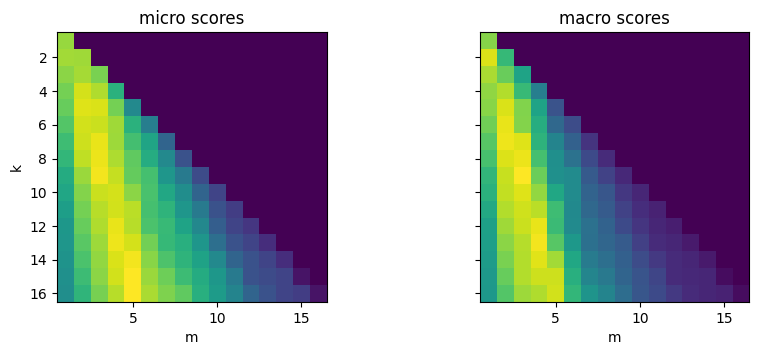

In [101]:
valid_labels = np.array(embs_valid["label_ids"])
valid_queries = np.array(embs_valid["embedding"], dtype=np.float32)
perf_micro, perf_macro = find_best_k_m(embs_train,
                                       valid_queries,
                                       valid_labels)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 3.5), sharey=True)
ax0.imshow(perf_micro)
ax1.imshow(perf_macro)

ax0.set_title("micro scores")
ax0.set_ylabel("k")
ax1.set_title("macro scores")
for ax in [ax0, ax1]:
    ax.set_xlim([0.5, 17 - 0.5])
    ax.set_ylim([17 - 0.5, 0.5])
    ax.set_xlabel("m")
plt.show()

In [102]:
k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
print(f"Best k: {k}, best m: {m}")

Best k: 15, best m: 5


The best performance is achieved when choosing a ration approx m/k = 1/3
When we retrieve the 15 nearest neighbors and then assign the labels that occurred at least 5 times.

Before we can slice the dataset, we need to remove the index since we cannot slice a FAISS index like the dataset.

In [103]:
# Train Naive Bayes + Embedding
embs_train.drop_index("embedding")
test_labels = np.array(embs_test["label_ids"])
test_queries = np.array(embs_test["embedding"], dtype=np.float32)

for train_slice in train_slices:
    # Get training slice and test data
    emb_train_tmp = embs_train.select(train_slice)
    emb_train_tmp.add_faiss_index("embedding")
    # Get best k, m values with validation set
    perf_micro, _ = find_best_k_m(emb_train_tmp, valid_queries, valid_labels)
    k, m = np.unravel_index(perf_micro.argmax(), perf_micro.shape)
    # Get predictions on test set
    scores, samples = emb_train_tmp.get_nearest_examples_batch("embedding",
                                                              test_queries,
                                                              k=int(k))
    y_pred = np.array([get_sample_preds(s, m) for s in samples])
    # Evaluate predictions
    clf_report = classification_report(test_labels, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
    
    # Store metrics
    macro_scores["Embedding"].append(clf_report["macro avg"]["f1-score"])
    micro_scores["Embedding"].append(clf_report["micro avg"]["f1-score"])

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

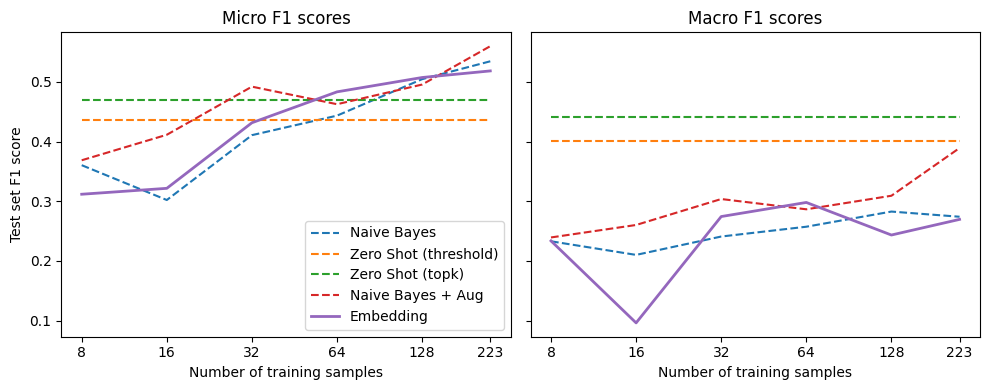

In [104]:
plot_metrics(micro_scores, macro_scores, train_samples, "Embedding")

Which method works best strongly depends on the domain.
The zero-shot pipeline's training data is quite different from the GitHub issues dataset we're using it on.
For a more common task such as sentiment analysis of reviews, the pipeline might work much better.
Similarly, the embeddings' quality depends on the model and the data it was trained on.

*Since you don't actually need to change anything in your code besided replacing the model checkopoint name to test another model, you can quickly try out a few models once you have the evaluation pipeline set up.*

## Fine-Tuning a Vanilla Transformer

If we have access to labeled data, we can simply fine-tune a pretrained transformer.

In [46]:
import torch
from transformers import (AutoTokenizer, AutoConfig, AutoModelForSequenceClassification)

model_ckpt = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

ds_enc = ds.map(tokenize, batched=True)
ds_enc = ds_enc.remove_columns(["labels", "text"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

The multilabel loss function expects the labels to be of type float, since it also allows for class probabilities instead of discrete labels. Therefore, we need to change the type of the column *label_ids*.

Since changing the format of the column element-wise does not play well with Arrow's typed format, we'll do a little workaround.
Create a new column with the labels (format of the column is inferred from the first element); delete the original column and rename the new one.

In [48]:
ds_enc.set_format("torch")
ds_enc = ds_enc.map(lambda x: {"label_ids_f": x["label_ids"].to(torch.float)}, remove_columns=["label_ids"])
ds_enc = ds_enc.rename_column("label_ids_f", "label_ids")

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

In [50]:
# since we are likely to overfit the training data due to its limted size, we set load_best_model_at_end
# and choose the best model based on the micro f1-score
from transformers import Trainer, TrainingArguments

training_args_fine_tune = TrainingArguments(
    output_dir="./results", num_train_epochs=20, learning_rate=3e-5,
    lr_scheduler_type='constant', per_device_train_batch_size=4,
    per_device_eval_batch_size=32, weight_decay=0.0,
    evaluation_strategy="epoch", save_strategy="epoch", logging_strategy="epoch",
    load_best_model_at_end=True, metric_for_best_model="micro f1",
    save_total_limit=1, log_level='error'
)

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


We need no make sure f1-score is calculated during the evaluation.
Because the model returns the logits, we first need to normalize the predictions with a sigmoid function and can then binarize them with a simple threshold. Then, we return the scores we are interested in from the classification report

In [57]:
from scipy.special import expit as sigmoid

def compute_metrics(pred):
    y_true = pred.label_ids
    y_pred = sigmoid(pred.predictions)
    y_pred = (y_pred>0.5).astype(float)

    clf_dict = classification_report(y_true, y_pred, target_names=all_labels,
                                    zero_division=0, output_dict=True)
    return {"micro f1": clf_dict["micro avg"]["f1-score"],
           "macro f1": clf_dict["macro avg"]["f1-score"]}

For each training set slice we train a classifier from scratch, load the best model at the end of training loop and store the results on the test set

In [58]:
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, config=config)

    trainer = Trainer(
        model=model, tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"]
    )

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (vanilla)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (vanilla)"].append(metrics["micro f1"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/1916074987.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.724200,0.633386,0.275862,0.143175
2,0.616600,0.596099,0.102804,0.053854
3,0.556600,0.543802,0.000000,0.000000
4,0.522900,0.505249,0.000000,0.000000
5,0.482000,0.490917,0.016129,0.018519
6,0.455700,0.471273,0.000000,0.000000
7,0.420900,0.428232,0.000000,0.000000
8,0.403700,0.415596,0.000000,0.000000
9,0.372700,0.410958,0.000000,0.000000
10,0.374500,0.410699,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/1916074987.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.643200,0.592078,0.211538,0.049383
2,0.556200,0.515623,0.015748,0.007937
3,0.497000,0.464966,0.016260,0.007937
4,0.425700,0.417252,0.000000,0.000000
5,0.394400,0.397006,0.000000,0.000000
6,0.359000,0.379161,0.000000,0.000000
7,0.350300,0.380948,0.000000,0.000000
8,0.331600,0.367223,0.000000,0.000000
9,0.322600,0.364121,0.000000,0.000000
10,0.308200,0.354927,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/1916074987.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.602300,0.563197,0.168539,0.065107
2,0.483300,0.443394,0.000000,0.000000
3,0.417700,0.409665,0.000000,0.000000
4,0.372100,0.373071,0.000000,0.000000
5,0.343500,0.362107,0.000000,0.000000
6,0.325800,0.358497,0.000000,0.000000
7,0.308200,0.348722,0.000000,0.000000
8,0.293600,0.343987,0.000000,0.000000
9,0.271400,0.338817,0.094488,0.044974
10,0.261800,0.337855,0.110236,0.045752


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/1916074987.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.548200,0.470537,0.061069,0.025397
2,0.409300,0.374932,0.000000,0.000000
3,0.352100,0.355929,0.000000,0.000000
4,0.331500,0.339937,0.064516,0.031746
5,0.309000,0.339184,0.064516,0.028674
6,0.286000,0.320034,0.319444,0.136400
7,0.273300,0.307452,0.267606,0.108039
8,0.254300,0.302307,0.397436,0.158445
9,0.227700,0.292162,0.392157,0.158064
10,0.200800,0.283958,0.376623,0.151470


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/1916074987.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.485800,0.382614,0.000000,0.000000
2,0.349000,0.343031,0.032520,0.016461
3,0.319100,0.324014,0.218978,0.081301
4,0.290100,0.314493,0.371795,0.137995
5,0.272600,0.297223,0.456790,0.177160
6,0.246000,0.276357,0.459627,0.178934
7,0.215700,0.266570,0.476744,0.176939
8,0.187500,0.260839,0.561798,0.287698
9,0.169200,0.234335,0.551724,0.291918
10,0.137300,0.249400,0.547486,0.293677


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/1916074987.py:8: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.433200,0.357927,0.153846,0.065359
2,0.337700,0.324794,0.287671,0.093333
3,0.298800,0.291729,0.457831,0.173694
4,0.257000,0.263348,0.487805,0.238234
5,0.217300,0.240551,0.551724,0.277198
6,0.181200,0.232837,0.604396,0.346688
7,0.150300,0.213711,0.611111,0.415125
8,0.121900,0.216448,0.640000,0.544465
9,0.094000,0.211425,0.656085,0.530062
10,0.077600,0.211658,0.683938,0.565216


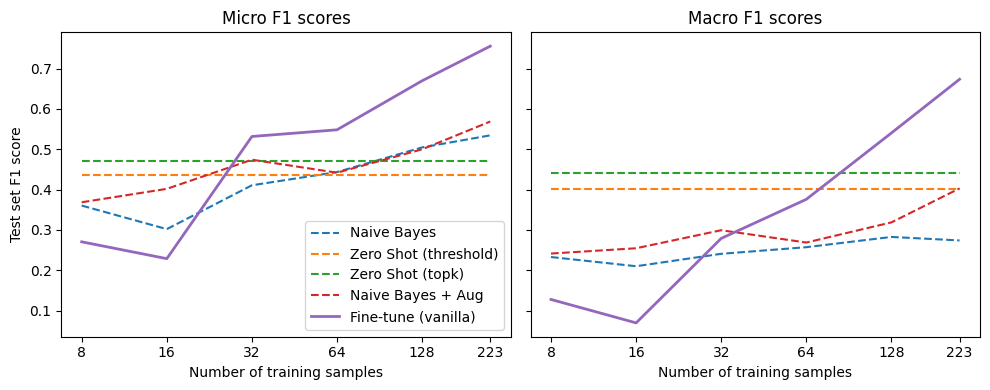

In [60]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (vanilla)")

Before we make use of the unlabeled part of our dataset, let's take a quick look to another promising approach

## In-Context and Few-Shot Learning with Prompts

This is different from the classic approach of adding a task-specific head and tuning the model parameters for the task.
This approach does not require any training data, but on the negative side it seems we can't leverage labeled data if we have access to it.

In [61]:
prompt = """\
Translate English to Franch:
thanks =>
"""

# Leveraging Unlabeled Data

We can leverage the pretrained weights for other tasks on a wide variety of texts.

There is a middle ground between retraining from scratch and just using the model as is for classification: **domain adaptation**
Continue training it on data from our domain. We use the classic language model objective of prediction masked words, which means *we don't need any labeled data*. Unlabeled data is often abundantly available.
The approach is agnostic to the downstream task.

## Fine-tuning a Language Model

fine-tune the pretrained BERT model with masked language modeling on the unlabeled portion of our dataset. We need 2 concepts: an extra step when tokenizing the data and a special data collator.

Special tokens to the sequence [CLS] AND [SEP], used for classification and next sentence prediction. When we do masked language modeling, we want to make sure we **don't** train the model to also predict these tokens. That's why we mask them from the loss, and we can get a mask when tokenizing by setting *return_special_tokens_mask=True*.

In [62]:
def tokenize(batch):
    return tokenizer(batch["text"], truncation=True,
                    max_length=128, return_special_tokens_mask=True)

ds_mlm = ds.map(tokenize, batched=True)
ds_mlm = ds_mlm.remove_columns(["labels", "text", "label_ids"])

Map:   0%|          | 0/223 [00:00<?, ? examples/s]

Map:   0%|          | 0/106 [00:00<?, ? examples/s]

Map:   0%|          | 0/111 [00:00<?, ? examples/s]

Map:   0%|          | 0/9303 [00:00<?, ? examples/s]

We are missing the mechanism to mask tokens in the input sequence and have the target tokens in the ouptuts.

An elegant solution is to use a data collator. It is the function that builds the bridge between the dataset and the model calls.

In [63]:
from transformers import DataCollatorForLanguageModeling, set_seed

data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer,
                                               mlm_probability=0.15)

In [65]:
set_seed(3)
data_collator.return_tensors = "np"
inputs = tokenizer("Transformers are awesome!", return_tensors="np")
outputs = data_collator([{"input_ids": inputs["input_ids"][0]}])

pd.DataFrame({
    "Original tokens": tokenizer.convert_ids_to_tokens(inputs["input_ids"][0]),
    "Masked tokens": tokenizer.convert_ids_to_tokens(outputs["input_ids"][0]),
    "Orignal input_ids": inputs["input_ids"][0],
    "Masked input_ids": outputs["input_ids"][0],
    "Labels": outputs["labels"][0]
}).T

,0,1,2,3,4,5
Original tokens,[CLS],transformers,are,awesome,!,[SEP]
Masked tokens,[CLS],transformers,are,awesome,[MASK],[SEP]
Orignal input_ids,101,19081,2024,12476,999,102
Masked input_ids,101,19081,2024,12476,103,102
Labels,-100,-100,-100,-100,999,-100


In [66]:
data_collator.return_tensors = "pt"

We are ready to fine-tune the masked language model

In [68]:
from transformers import AutoModelForMaskedLM

training_args = TrainingArguments(
    output_dir=f"{model_ckpt}-issues-128", per_device_train_batch_size=32,
    logging_strategy="epoch", evaluation_strategy="epoch", save_strategy="no",
    num_train_epochs=16, push_to_hub=True, log_level="error", report_to="none"
)

trainer = Trainer(
    model=AutoModelForMaskedLM.from_pretrained("bert-base-uncased"),
    tokenizer=tokenizer, args=training_args, data_collator=data_collator,
    train_dataset=ds_mlm["unsup"], eval_dataset=ds_mlm["train"]
)

trainer.train()

trainer.push_to_hub("Training completed!")

/home/ssanchez/env/transformers/lib/python3.8/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/tmp/ipykernel_1764707/639518540.py:9: FutureWarning: `tokenizer` 

{'loss': 2.1003, 'grad_norm': 6.397911071777344, 'learning_rate': 4.6875e-05, 'epoch': 1.0}
{'eval_loss': 1.702514886856079, 'eval_runtime': 0.5729, 'eval_samples_per_second': 389.271, 'eval_steps_per_second': 48.877, 'epoch': 1.0}
{'loss': 1.6316, 'grad_norm': 5.294964790344238, 'learning_rate': 4.375e-05, 'epoch': 2.0}
{'eval_loss': 1.5260438919067383, 'eval_runtime': 0.5756, 'eval_samples_per_second': 387.444, 'eval_steps_per_second': 48.648, 'epoch': 2.0}
{'loss': 1.4974, 'grad_norm': 5.470129013061523, 'learning_rate': 4.0625000000000005e-05, 'epoch': 3.0}
{'eval_loss': 1.3546340465545654, 'eval_runtime': 0.5771, 'eval_samples_per_second': 386.396, 'eval_steps_per_second': 48.516, 'epoch': 3.0}
{'loss': 1.397, 'grad_norm': 3.948866367340088, 'learning_rate': 3.7500000000000003e-05, 'epoch': 4.0}
{'eval_loss': 1.339883804321289, 'eval_runtime': 0.5811, 'eval_samples_per_second': 383.763, 'eval_steps_per_second': 48.185, 'epoch': 4.0}
{'loss': 1.3339, 'grad_norm': 5.369665622711182,

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/4.79k [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/sergi24sanchez/bert-base-uncased-issues-128/commit/e76737fe39b3679749aa40da1adfa17cb09507d8', commit_message='Training completed!', commit_description='', oid='e76737fe39b3679749aa40da1adfa17cb09507d8', pr_url=None, repo_url=RepoUrl('https://huggingface.co/sergi24sanchez/bert-base-uncased-issues-128', endpoint='https://huggingface.co', repo_type='model', repo_id='sergi24sanchez/bert-base-uncased-issues-128'), pr_revision=None, pr_num=None)

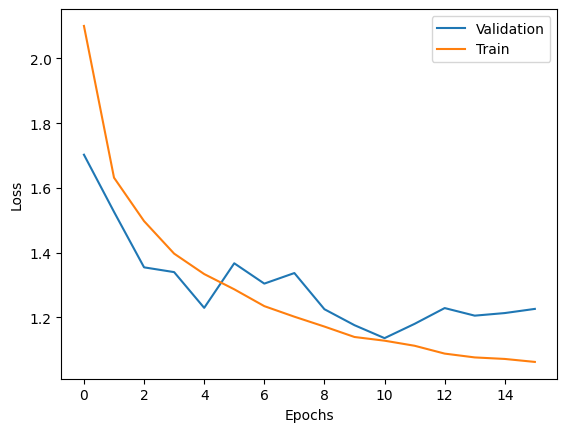

In [69]:
df_log = pd.DataFrame(trainer.state.log_history)

(df_log.dropna(subset=["eval_loss"]).reset_index()["eval_loss"]
.plot(label="Validation"))
df_log.dropna(subset=["loss"]).reset_index()["loss"].plot(label="Train")

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc="upper right")
plt.show()

In [71]:
model_ckpt = f"{model_ckpt}-issues-128"
config = AutoConfig.from_pretrained(model_ckpt)
config.num_labels = len(all_labels)
config.problem_type = "multi_label_classification"

for train_slice in train_slices:
    model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                              config=config)
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        args=training_args_fine_tune,
        compute_metrics=compute_metrics,
        train_dataset=ds_enc["train"].select(train_slice),
        eval_dataset=ds_enc["valid"],
    )

    trainer.train()
    pred = trainer.predict(ds_enc["test"])
    metrics = compute_metrics(pred)
    macro_scores["Fine-tune (DA)"].append(metrics["macro f1"])
    micro_scores["Fine-tune (DA)"].append(metrics["micro f1"])

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/2303842545.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.635200,0.558517,0.000000,0.000000
2,0.509600,0.482681,0.000000,0.000000
3,0.433400,0.438968,0.000000,0.000000
4,0.395500,0.413505,0.000000,0.000000
5,0.365200,0.396028,0.000000,0.000000
6,0.339800,0.385632,0.000000,0.000000
7,0.314600,0.378558,0.000000,0.000000
8,0.305000,0.372665,0.000000,0.000000
9,0.281900,0.368335,0.000000,0.000000
10,0.266600,0.364761,0.000000,0.000000


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/2303842545.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.651400,0.529626,0.147059,0.052910
2,0.463000,0.436027,0.000000,0.000000
3,0.386900,0.394411,0.000000,0.000000
4,0.347000,0.374057,0.000000,0.000000
5,0.316300,0.363799,0.000000,0.000000
6,0.292900,0.355933,0.000000,0.000000
7,0.274000,0.347830,0.000000,0.000000
8,0.248800,0.343224,0.048780,0.024215
9,0.234700,0.338720,0.080000,0.037563
10,0.210200,0.334841,0.180451,0.083415


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/2303842545.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.581100,0.451887,0.000000,0.000000
2,0.400500,0.383543,0.000000,0.000000
3,0.340400,0.360635,0.000000,0.000000
4,0.310600,0.348833,0.000000,0.000000
5,0.279100,0.336007,0.032787,0.016825
6,0.249100,0.324152,0.235294,0.102748
7,0.223900,0.316086,0.295775,0.123737
8,0.198000,0.310285,0.303448,0.123091
9,0.175600,0.304819,0.322148,0.129806
10,0.157800,0.302159,0.333333,0.148079


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/2303842545.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.509000,0.385205,0.000000,0.000000
2,0.352700,0.350469,0.000000,0.000000
3,0.316000,0.325790,0.195489,0.072222
4,0.277600,0.302577,0.431373,0.174828
5,0.235600,0.283735,0.445860,0.176904
6,0.198400,0.271889,0.462500,0.200088
7,0.165300,0.255374,0.469136,0.218270
8,0.139500,0.247564,0.506024,0.272430
9,0.119500,0.243558,0.514970,0.285502
10,0.105100,0.239911,0.511905,0.288092


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/2303842545.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.431700,0.359005,0.000000,0.000000
2,0.325900,0.311464,0.389262,0.161111
3,0.278600,0.278157,0.493827,0.191078
4,0.226700,0.243292,0.503067,0.225217
5,0.179100,0.213765,0.622222,0.444112
6,0.136900,0.195271,0.611111,0.431556
7,0.105500,0.183644,0.627027,0.452235
8,0.083400,0.190120,0.622951,0.468365
9,0.070000,0.181654,0.677083,0.535315
10,0.059300,0.175487,0.673575,0.527529


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased-issues-128 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_1764707/2303842545.py:9: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Epoch,Training Loss,Validation Loss,Micro f1,Macro f1
1,0.401600,0.337788,0.153846,0.065359
2,0.301800,0.269172,0.462500,0.180784
3,0.230600,0.217669,0.552941,0.266796
4,0.165900,0.185238,0.719212,0.598402
5,0.120300,0.183823,0.726368,0.648349
6,0.089700,0.155392,0.754902,0.659728
7,0.068200,0.156230,0.742574,0.667277
8,0.051500,0.149189,0.782609,0.733752
9,0.042100,0.151718,0.766990,0.699468
10,0.034900,0.158361,0.760976,0.703604


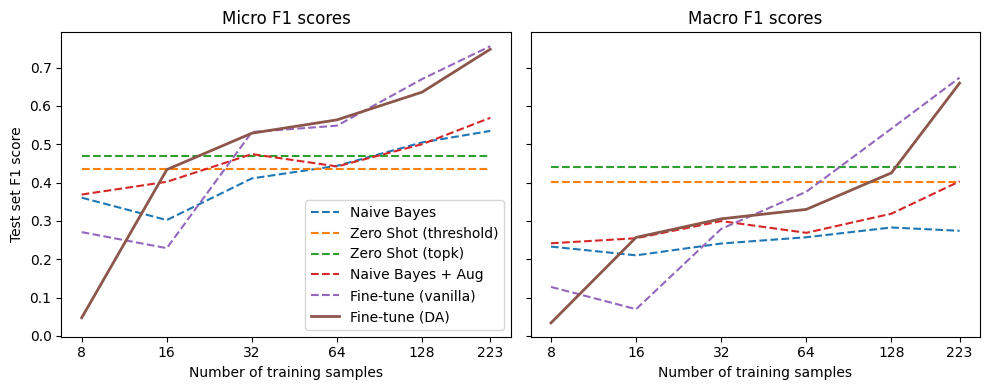

In [72]:
plot_metrics(micro_scores, macro_scores, train_samples, "Fine-tune (DA)")